In [1]:
%pylab inline
plt.style.use('../../matplotlib.mplstyle')
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import Angle, Latitude, Longitude
# gala

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import gala.integrate as gi
from gala.units import galactic

import pynbody
 
import bfe

import sys
sys.path.append('../')
import coefficients_smoothing
import nba

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Functions

# Path to coefficients


def get_coefficients(path, n_snaps, nmax, lmax, taxis=1):
    S_matrix = np.zeros((n_snaps, nmax+1, lmax+1, lmax+1))
    T_matrix = np.zeros((n_snaps, nmax+1, lmax+1, lmax+1))
    
    for i in range(n_snaps):
        coeff = np.loadtxt(path+"_{:03d}.txt".format(i))
        S = coeff[:,0]
        SS = coeff[:,1]
        T = coeff[:,taxis]
        TT = coeff[:,3]
        ST = coeff[:,4]
        S_matrix[i] = coefficients_smoothing.reshape_matrix(S, nmax, lmax, lmax)
        T_matrix[i] = coefficients_smoothing.reshape_matrix(T, nmax, lmax, lmax)
        SS_matrix = coefficients_smoothing.reshape_matrix(SS, nmax, lmax, lmax)
        TT_matrix = coefficients_smoothing.reshape_matrix(TT, nmax, lmax, lmax)
        ST_matrix = coefficients_smoothing.reshape_matrix(ST, nmax, lmax, lmax)

        S_matrix[i], T_matrix[i], _ = coefficients_smoothing.smooth_coeff_matrix(S_matrix[i], T_matrix[i], SS_matrix,
                                                                        TT_matrix, ST_matrix, nmax=20, 
                                                                        lmax=20, mmax=20, mass=1.853e-6, 
                                                                         sn=7, sn_out=0)
    return S_matrix, T_matrix



def get_center(coeff_path, all_info=0):
    line = linecache.getline(coeff_path,1)
    line2 = line.split(":",1)[1].rstrip('\n')
    list_str = line2.replace('[', '').replace(']', '').replace(',','').split(' ')
    list_com = list(filter(None, list_str))
    
    if all_info==1:
        nmax = int(list_com[0])
        lmax = int(list_com[2])
        rs_mw = float(list_com[4])
        pmass = float(list_com[6])
        return nmax, lmax, rs_mw, pmass
    else:
        xcom = float(list_com[8])
        ycom = float(list_com[9])
        zcom = float(list_com[10])
        return np.array([xcom, ycom, zcom])

In [3]:
orbit = np.loadtxt('../data/LMC5_100Mb1_orbit.txt')


In [4]:
# Plot density contours in spherical galactic shell  
    

# LMC as a point mass
# LMC orbit
# LMC debris as particles


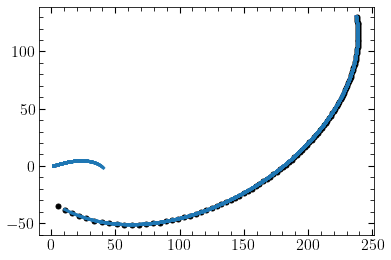

In [5]:
for k in range(110):
    plot(orbit[:k,7], orbit[:k,8], c='C0')
    plot(orbit[:k,1], orbit[:k,2], c='C0')

    scatter(orbit[k,7], orbit[k,8], c='k')
    
#xlim(-250, 250)
#ylim(-250, 250)

In [6]:
# BFEs 

# Compute density in galactocentric coorinates. 
# Transform to equatorial


In [7]:
grid_size = [-300, 300]
x = np.linspace(grid_size[0], grid_size[1], 128)
y = np.linspace(grid_size[0], grid_size[1], 128)
z = np.linspace(grid_size[0], grid_size[1], 128)

grid = np.meshgrid(x, y, z)    

In [8]:
xyz = np.zeros((3, 128**3))
xyz[0] = grid[0].flatten()
xyz[1] = grid[1].flatten()
xyz[2] = grid[2].flatten()

In [9]:
rmax = 100
rmin = 30
r = np.sqrt(np.sum(xyz**2, axis=0))
rcut = np.where((r<rmax) & (r>rmin)) 

In [10]:
len(xyz[0])

2097152

In [11]:
np.shape(xyz.T[rcut].T)

(3, 38560)

In [12]:
coefficients = "../data/BFE_MWLMC5_b1snap"
# Coefficients

S_mw, T_mw = get_coefficients(coefficients, 110, nmax=20, lmax=20, taxis=2)


/home/ngc/Work/research/MW_viz/mwlmc/wake/../coefficients_smoothing.py:142: RuntimeWarning: invalid value encountered in double_scalars
  bt = 1 / (1 + (varT/T**2))


In [13]:
m=1
rs=40.85

In [14]:
pot = gp.SCFPotential(m=m*u.Msun, r_s=rs*u.kpc, Snlm=S_mw[109], Tnlm=T_mw[109], units=galactic)

In [15]:
rho = pot.density(xyz.T[rcut].T)


In [16]:
halo_kin = nba.kinematics.Kinematics(xyz.T[rcut], xyz.T[rcut])

In [17]:
lon = np.arange(0, 361, 1)
lat = np.arange(-90, 90.5, 0.5)
longitude, latitude = meshgrid(lon, lat)

In [18]:
lon2 = Longitude(longitude, unit=u.deg, wrap_angle=180*u.deg)  # Could also use Angle
lat2 = Latitude(latitude, unit=u.deg)  # Astropy Quantity
c = SkyCoord(lon2, lat2, frame='galactic', distance=50*u.kpc)

In [19]:
rho = pot.density(c.cartesian.xyz)

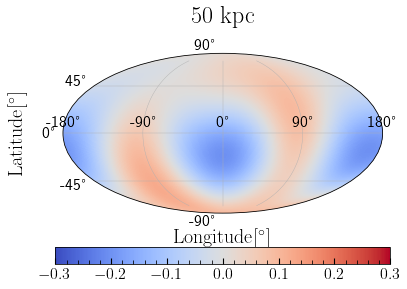

<Figure size 432x302.4 with 0 Axes>

In [20]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
drho = (rho.reshape(361, 361))/np.mean(rho)-1
lon = np.arange(-180, 181, 1)
lat = np.arange(-90, 90.5, 0.5)
im = ax.pcolormesh(lon*np.pi/180.0, lat*np.pi/180, drho, cmap=plt.cm.coolwarm, vmin=-0.3, vmax=0.3)
colorbar(im, orientation='horizontal')
ax.grid(which='major', linewidth=0.4)
ax.set_xlabel(r'$\rm{Longitude} [^{\circ}]$', labelpad=15)
ax.set_ylabel(r'$\rm{Latitude} [^{\circ}]$', labelpad=15)
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticks([-np.pi/2,-np.pi/4,  0, np.pi/4, np.pi/2])
ax.set_title(r'$50\ \rm{kpc}$', y=1.15)
plt.show()
savefig('wake_icrs_50kpc.png', bbox_inches='tight')

In [33]:
# IN ICRS coordinates
lon2 = Longitude(longitude, unit=u.deg, wrap_angle=180*u.deg)  # Could also use Angle
lat2 = Latitude(latitude, unit=u.deg)  # Astropy Quantity
c2 = SkyCoord(lon2, lat2, frame='icrs', distance=70*u.kpc)

In [34]:
rho2 = pot.density(c2.galactic.cartesian.xyz)

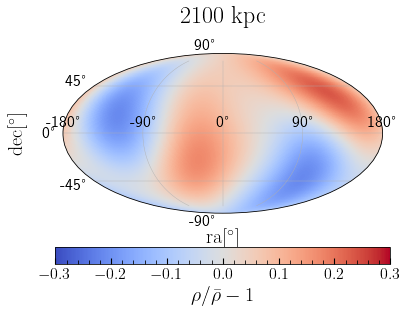

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
drho2 = (rho2.reshape(361, 361))/np.mean(rho2)-1
lon = np.arange(-180, 181, 1)
lat = np.arange(-90, 90.5, 0.5)
im = ax.pcolormesh(lon*np.pi/180.0, lat*np.pi/180, drho2, cmap=plt.cm.coolwarm, vmin=-0.3, vmax=0.3)
cbar = colorbar(im, orientation='horizontal')
cbar.set_label(r'$\rho / \bar{\rho} -1$')
ax.grid(which='major', linewidth=0.4)
ax.set_xlabel(r'$\rm{ra} [^{\circ}]$', labelpad=15)
ax.set_ylabel(r'$\rm{dec} [^{\circ}]$', labelpad=15)
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticks([-np.pi/2,-np.pi/4,  0, np.pi/4, np.pi/2])
ax.set_title(r'$2100\ \rm{kpc}$', y=1.15)
savefig('wake_icrs_70kpc.png', bbox_inches='tight')